## Model Training: LSTM

In [12]:
import gc
import sys
sys.path.append('../')
sys.path.append('../../../')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from scipy import signal
from scipy.signal import resample, hilbert
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import earthquake_detection.architectures as architectures
import earthquake_detection.training_utils as training_utils

plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

In [2]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_10000.npy')

# Load metadata
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_10000.feather')
metadata = metadata.reset_index()

In [3]:
raw_signals.shape

(10000, 6000, 3)

In [4]:
raw_signals[0][:,2]

array([-0.        ,  0.00024294,  0.00068383, ...,  0.00162756,
        0.00026638,  0.        ], dtype=float32)

In [13]:
metadata['label'] = [1 if label=='earthquake_local' else 0 for label in metadata['trace_category']]
classifier_labels = metadata['label'].values

In [5]:
def hilbert_transform_rolling_avg(raw_signal, resampled=True):
    sos = signal.butter(4, (1,49.9), 'bandpass', fs=100, output='sos') # filter signal from 1-50 Hz, 4th order filter
    filtered = signal.sosfilt(sos, raw_signal[:,2]) # use only z-axis signal component
    analytic_signal = hilbert(filtered) # apply hilbert transform to get signal envelope
    amplitude_envelope = np.abs(analytic_signal) # get only positive envelope
    env_series = pd.Series(amplitude_envelope) # convert to a series to be compatible with pd.Series rolling mean calc
    rolling_obj = env_series.rolling(200) # 2-second rolling mean (100 Hz * 2 sec = 200 samples)
    rolling_average = rolling_obj.mean()
    rolling_average_demeaned = rolling_average[199:] - np.mean(rolling_average[199:])
    rolling_average_padded = np.pad(rolling_average_demeaned, (199,0), 'constant', constant_values=(list(rolling_average_demeaned)[0])) # pad to remove nans created by rolling mean
    if resampled:
        return signal.resample(rolling_average_padded, 300) # resample signal from 6000 samples to 300 to reduce size
    else:
        return rolling_average_padded

In [6]:
# For demonstration/plotting purposes only
signal_envelopes = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=False) for raw_signal in raw_signals])

In [7]:
# These are the envelopes that will be used for model training
signal_envelopes_resamp = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=True) for raw_signal in raw_signals])

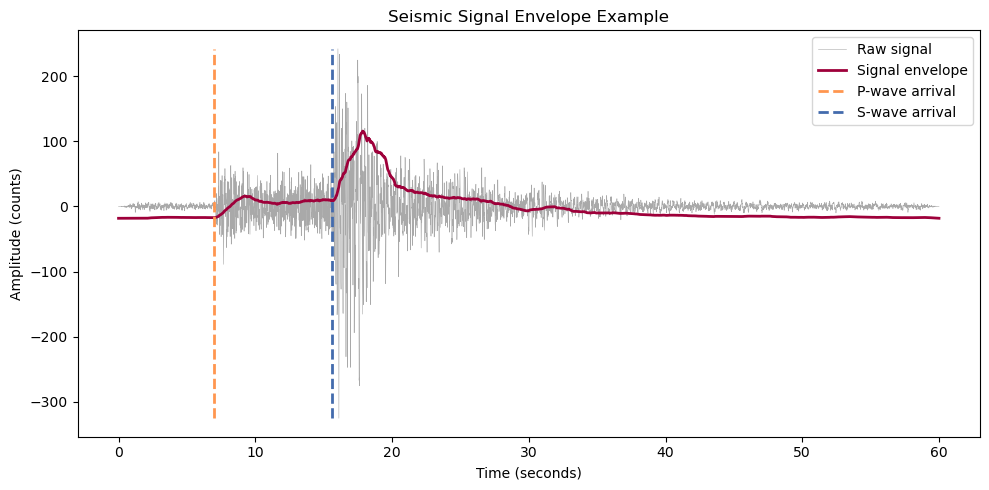

In [8]:
i = 57
fig, ax = plt.subplots(1,1,figsize=(10,5))
sig = raw_signals[i][:,2]
ax.plot(np.linspace(0,60,6000), sig, color='darkgrey', linewidth=0.4, label='Raw signal')
ax.plot(np.linspace(0,60,6000), signal_envelopes[i], color='xkcd:cranberry', linewidth=2, label='Signal envelope')
p_wave = metadata.iloc[i]['p_arrival_sample']
s_wave = metadata.iloc[i]['s_arrival_sample']
ax.vlines(p_wave/100.0, sig.min(), sig.max(), color='xkcd:pastel orange', linewidth=2, linestyle='--', label='P-wave arrival')
ax.vlines(s_wave/100.0, sig.min(), sig.max(), color='xkcd:french blue', linewidth=2, linestyle='--', label='S-wave arrival')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude (counts)')
ax.set_title('Seismic Signal Envelope Example')
ax.legend()
plt.tight_layout()

In [9]:
earthquakes_indices = np.array(list(metadata[metadata['trace_category']=='earthquake_local'].index))
raw_signals_earthquakes_only = raw_signals[earthquakes_indices]
envelopes_earthquakes_only = signal_envelopes_resamp[earthquakes_indices]
metadata_earthquakes_only = metadata[metadata['trace_category']=='earthquake_local']

In [37]:
signal_envelopes_resamp = np.reshape(signal_envelopes_resamp, (signal_envelopes_resamp.shape[0], 1, signal_envelopes_resamp.shape[1]))
envelopes_earthquakes_only = np.reshape(envelopes_earthquakes_only, (envelopes_earthquakes_only.shape[0], 1, envelopes_earthquakes_only.shape[1]))

In [21]:
def build_compile_classification_lstm(input_shape, learning_rate=1e-5, loss='binary_crossentropy', metrics=['accuracy']):
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

Epoch 1/20


/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5290 - loss: 0.6894 - val_accuracy: 0.5387 - val_loss: 0.6849 - learning_rate: 1.0000e-05
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5681 - loss: 0.6817 - val_accuracy: 0.5900 - val_loss: 0.6763 - learning_rate: 1.0000e-05
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6277 - loss: 0.6728 - val_accuracy: 0.6656 - val_loss: 0.6659 - learning_rate: 1.0000e-05
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6901 - loss: 0.6615 - val_accuracy: 0.7088 - val_loss: 0.6535 - learning_rate: 1.0000e-05
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7220 - loss: 0.6490 - val_accuracy: 0.7394 - val_loss: 0.6388 - learning_rate: 1.0000e-05
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7585 - loss: 0.6321 - val_accuracy: 0.7556 - val_loss: 0.6217 - learning_rate: 1.0000e-05
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7771 - lo

2025-01-24 10:59:11.433263: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Model accuracy: 0.8435
 Model precision: 0.7935153583617748
 Model recall: 0.929070929070929
 Model F1 score: 0.8559595029912563


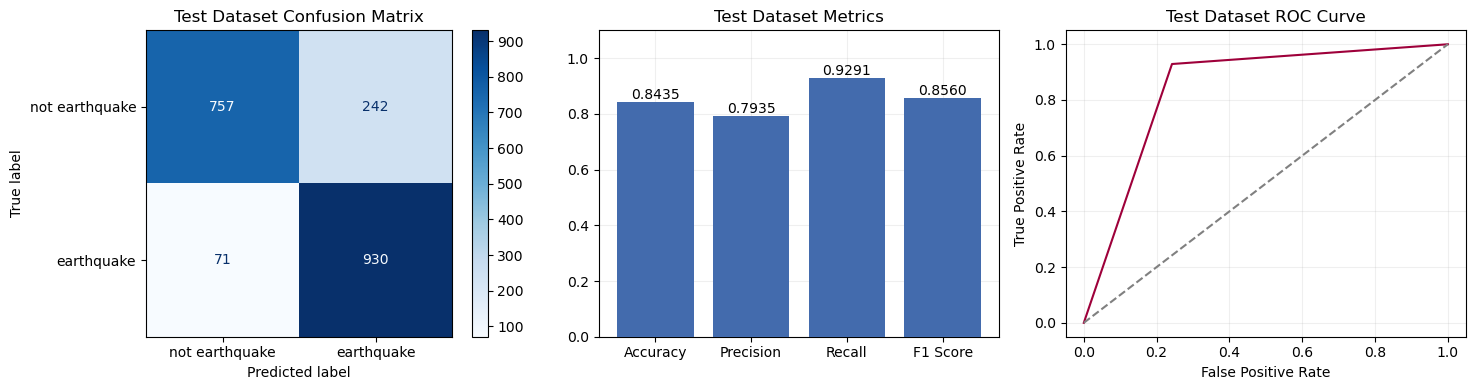

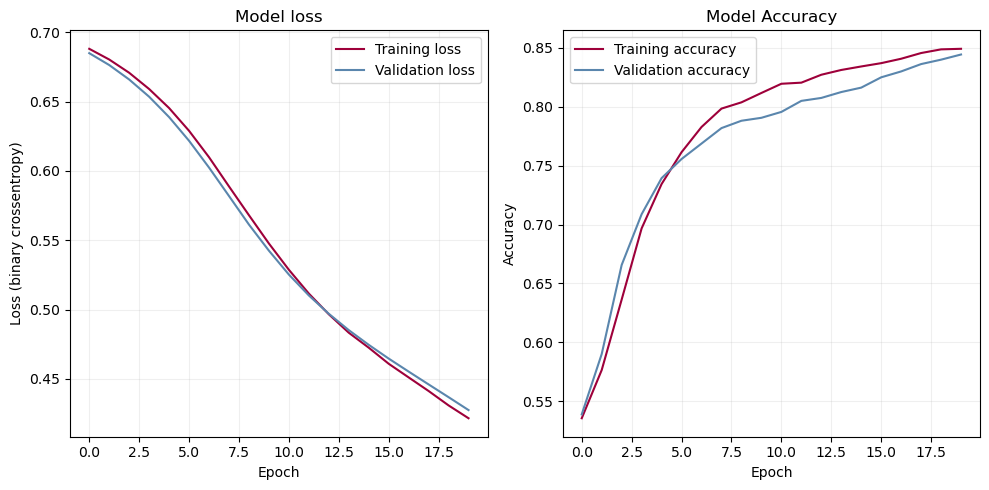

In [38]:
# Set up model callbacks
epochs = 20
callbacks_c = architectures.callbacks_setup(model_tag='lstm_classification', epochs=epochs)

# Fit model
train_dataset_c, val_dataset_c, test_dataset_c = training_utils.prepare_datasets(imgs=signal_envelopes_resamp, labels=classifier_labels, batch_size=32)
input_shape = (signal_envelopes_resamp.shape[1], signal_envelopes_resamp.shape[2])
classifier_model = build_compile_classification_lstm(input_shape=input_shape, learning_rate=1e-5, loss='binary_crossentropy', metrics=['accuracy'])
classifier_history = classifier_model.fit(train_dataset_c, epochs=epochs, callbacks=callbacks_c, validation_data=val_dataset_c)

# Evaluate model and plot results
training_utils.evaluate_classification_model(classifier_model, test_dataset_c)
training_utils.plot_training_history(classifier_history)

In [22]:
def build_compile_regression_lstm(input_shape, learning_rate=1e-4, loss='mse', metrics=['mae']):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(32, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.1474 - mae: 1.4740 - val_loss: 2.5407 - val_mae: 1.2550 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3150 - mae: 1.1764 - val_loss: 1.5430 - val_mae: 0.8654 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4623 - mae: 0.8506 - val_loss: 1.0611 - val_mae: 0.7342 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0164 - mae: 0.7227 - val_loss: 0.8527 - val_mae: 0.6814 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8426 - mae: 0.6671 - val_loss: 0.7350 - val_mae: 0.6432 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7167 - mae: 0.6376 - val_loss: 0.6780 - val_mae: 0.6281 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6325 - mae: 0.6066 - val_loss: 0.6511 - val_mae: 0.6134

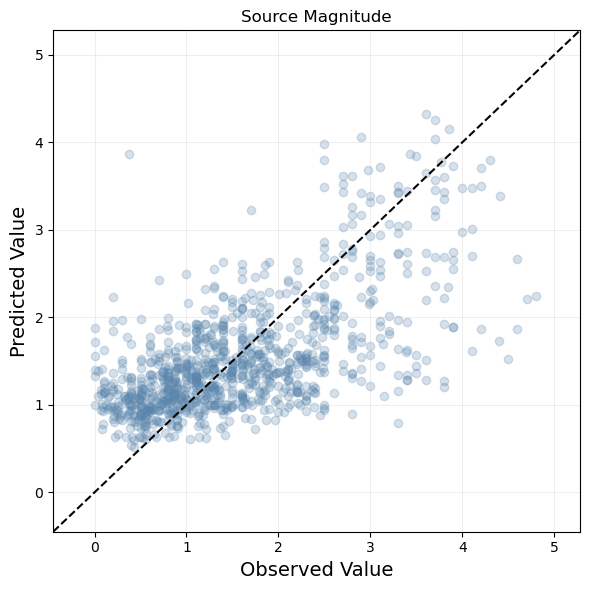

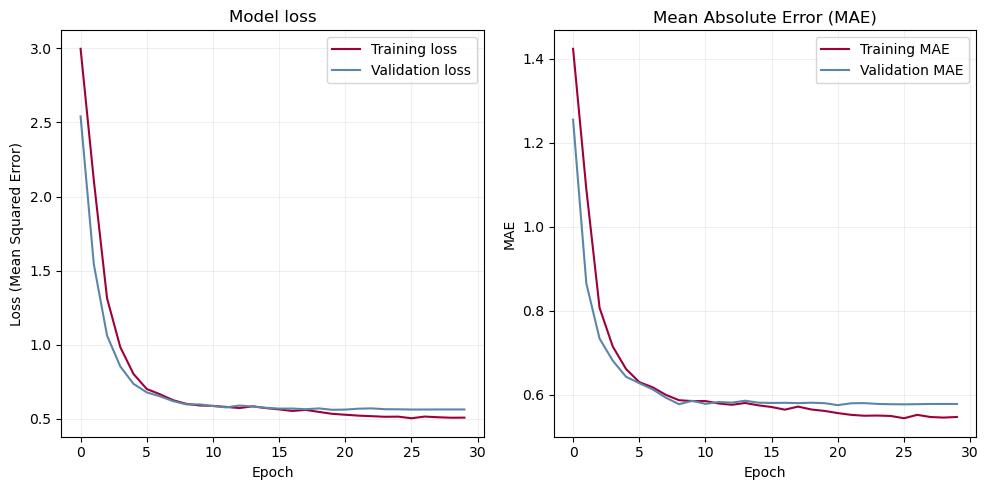

In [43]:
# Set up model callbacks
epochs = 20
callbacks_mag = architectures.callbacks_setup(model_tag='lstm_regression_magnitude', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['source_magnitude'])
train_dataset_mag, val_dataset_mag, test_dataset_mag = training_utils.prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels, batch_size=32)
input_shape = (envelopes_earthquakes_only.shape[1], envelopes_earthquakes_only.shape[2])
model_magnitude = build_compile_regression_lstm(input_shape=input_shape, learning_rate=1e-4, loss='mse', metrics=['mae'])
model_magnitude_history = model_magnitude.fit(train_dataset_mag, epochs=epochs, callbacks=callbacks_mag, validation_data=val_dataset_mag)

# Evaluate model and plot results
training_utils.evaluate_regression_model(model_magnitude, test_dataset_mag, 'Source Magnitude', scaler=None)
training_utils.plot_training_history(model_magnitude_history)